In [2]:
!pip install --upgrade transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 32.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylin

In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12

In [4]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset

In [5]:
corpus_path = 'corpus.csv'
df = pd.read_csv(corpus_path, encoding='utf-8')
df['text'] = df['Title'] + '. ' + df['Body']

In [7]:
df.head()

,Year,Title,Body,Category,text
0,1979,yoashico inca,"ja rekena inkan jane ronki ipaonike, yoashiko ...",cuento,yoashico inca. ja rekena inkan jane ronki ipao...
1,1979,yoashico incan jato jascara apaoni,ikonbires jakonma ronki ipaonike yoashiko inka...,cuento,yoashico incan jato jascara apaoni. ikonbires ...
2,1979,yoashico inca betan jahuen rayos ini,ja yoaxiko inka ronki rayossha ipaonike. ja ja...,cuento,yoashico inca betan jahuen rayos ini. ja yoaxi...
3,1979,jascatax manxanteo betan abobo jonini,"askara jakonma shinanya ixon ronki aka iki, ja...",cuento,jascatax manxanteo betan abobo jonini. askara ...
4,1979,inca baque miincani betan jenen ehuani,moa yoashiko inka reteax iiti chonka baritia p...,cuento,inca baque miincani betan jenen ehuani. moa yo...


In [8]:
from tokenizers import ByteLevelBPETokenizer

tokenizer = ByteLevelBPETokenizer()
tokenizer.train(files=[corpus_path], vocab_size=52000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

tokenizer.save_model(".", "shipibo_tokenizer")

['./shipibo_tokenizer-vocab.json', './shipibo_tokenizer-merges.txt']

In [9]:
from transformers import GPT2TokenizerFast

# Cargar el tokenizador desde los archivos vocab y merges
tokenizer = GPT2TokenizerFast(
    vocab_file="shipibo_tokenizer-vocab.json",
    merges_file="shipibo_tokenizer-merges.txt"
)

# Añadir tokens especiales
tokenizer.add_special_tokens({
    "pad_token": "<pad>",
    "unk_token": "<unk>",
    "mask_token": "<mask>",
    "bos_token": "<s>",
    "eos_token": "</s>",
})

# Verificar si se han añadido correctamente los tokens especiales
print("Tokens especiales añadidos:", tokenizer.special_tokens_map)

Tokens especiales añadidos: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'mask_token': '<mask>'}


In [10]:
# Ejemplo de texto en Shipibo-Konibo
input_text = "Huestíora joni ronqui"
tokens = tokenizer.encode(input_text)
print("Tokens:", tokens)

# Des-tokenización
decoded_text = tokenizer.decode(tokens)
print("Texto decodificado:", decoded_text)

Tokens: [44, 89, 992, 88, 132, 260, 363, 321, 795, 85, 89, 77]
Texto decodificado: Huestíora joni ronqui


In [21]:
from transformers import GPT2Config, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset

# Crear el modelo desde cero
config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    n_positions=1024,
    n_ctx=1024,
    n_embd=768,
    n_layer=12,
    n_head=12,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id
)

model = GPT2LMHeadModel(config)

# Crear el dataset de Hugging Face
corpus_path = 'corpus.csv'
df = pd.read_csv(corpus_path)
df['text'] = df['Title'] + ' ' + df['Body']
dataset = Dataset.from_pandas(df[['text']])

# Tokenizar el corpus
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Crear el data collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Configurar los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    num_train_epochs=50,
    per_device_train_batch_size=4,
    save_steps=10_000,
    save_total_limit=2,
    prediction_loss_only=True,
)

# Inicializar el Trainer y entrenar el modelo
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets,
)



Map:   0%|          | 0/148 [00:00<?, ? examples/s]

In [22]:
from transformers import TrainerCallback

class PerplexityCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            perplexity = math.exp(logs['loss']) if 'loss' in logs else None
            if perplexity:
                logs['perplexity'] = perplexity
            print(f"Epoch: {state.epoch}, Perplexity: {perplexity}")

# Agregar el callback al trainer para obtener mediciones del perplexity
trainer.add_callback(PerplexityCallback())

In [23]:

trainer.train()

Step,Training Loss
500,5.492600
1000,3.007000
1500,1.520800


Epoch: 13.513513513513514, Perplexity: 242.88789513525765
Epoch: 27.027027027027028, Perplexity: 20.226628927540002
Epoch: 40.54054054054054, Perplexity: 4.575884438800577
Epoch: 50.0, Perplexity: None


TrainOutput(global_step=1850, training_loss=2.882277865023226, metrics={'train_runtime': 822.1303, 'train_samples_per_second': 9.001, 'train_steps_per_second': 2.25, 'total_flos': 1933561036800000.0, 'train_loss': 2.882277865023226, 'epoch': 50.0})

In [24]:
# Guardar el modelo y el tokenizador
trainer.save_model("./results")  # Esto guarda el modelo, la configuración y el tokenizador
tokenizer.save_pretrained("./results")

('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/vocab.json',
 './results/merges.txt',
 './results/added_tokens.json',
 './results/tokenizer.json')

In [25]:
# Cargar el modelo entrenado
model = GPT2LMHeadModel.from_pretrained('./results')


In [26]:
import re

def capitalize_sentences(text):
    sentences = re.split('(?<=[.!?]) +', text)  # Dividir el texto en oraciones
    capitalized_sentences = [sentence.capitalize() for sentence in sentences]
    return ' '.join(capitalized_sentences)

# Función para generar texto

def generate_story(prompt, max_length=512, num_return_sequences=1):
    inputs = tokenizer(prompt, return_tensors='pt')
    outputs = model.generate(
        inputs['input_ids'],
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=True,  # Para generar texto de manera más creativa
        top_k=50,  # Para limitar el número de palabras a considerar para cada paso
        top_p=0.95  # Para la estrategia de muestreo de núcleo (nucleus sampling)
    )

    stories = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    capitalized_stories = [capitalize_sentences(story) for story in stories]
    return capitalized_stories


# Ejemplo de uso
prompt = "moatian ronki ipaonike"
generated_stories = generate_story(prompt, max_length=300, num_return_sequences=3)


for i, story in enumerate(generated_stories):
    print(f"Cuento {i + 1}:\n{story}\n")

Cuento 1:
Moatian ronki ipaonike jatibi jawekibo joni ronki ipaonike, jemankobo ainbo betan wanoa. Ja kakin jato ikina ipaonike,qki. Eag ati xeati xeai. Jatian ronki ipaonike, atsa yometsonki ika iki. Akaitian ronki ipaonike. Jaskaaxon, shipibo jonibo. Jatian ronki ipaonike, na yoikin, atsa akin jato onan; ramara jaska akai, onan; jawetianbi; jatibi jaweki atiki alicha. Meni joai. Minbiribi jato axea iki. Jatian ixon jato aka iki, noabiribi akana iki. Jatian ronki ika iki. Jaskatai ninkataxxonki joa iki, jawen ibonra jakiribi jonixon, jene tsakaax, joo ika iki, jawen rayosbaina iki; jatibi jaweki reteai, jatibi jaweki ika iki, en too yoinabo. Joxon, jaskashontax akin. Jaskataxki joni. Jato yoia iki moara icha riki piti ixon. Jaskara joi; ja bake. Jatian jato aka iki. Jato jaskaaki, kapetan ewa, ja ika iki, pei xatebeirani; jato aka iki. Jatianki ika iki; ratetani. Caaxki, jawen ibon baneti. Jaskataxki ika iki, ka keantan, moa joni karibaa iki, icha riki wainko paranta akinki jato aka i

# Metricas para evaluar el cuento generado

In [27]:
# Calcular la perplejidad
import math

def compute_perplexity(eval_dataset):
    eval_results = trainer.evaluate(eval_dataset)
    perplexity = math.exp(eval_results['eval_loss'])
    return perplexity

# Crear el dataset de evaluación (usamos el mismo dataset tokenizado para simplicidad)
eval_dataset = tokenized_datasets

# Calcular la perplejidad
perplexity = compute_perplexity(eval_dataset)
print(f'Perplejidad: {perplexity}')


Epoch: 50.0, Perplexity: None
Perplejidad: 1.366558935280645


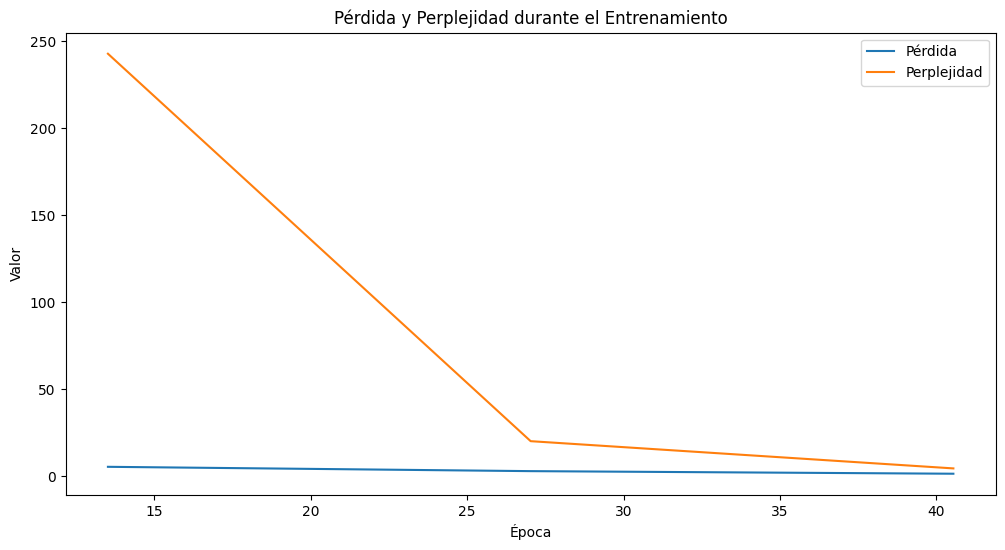

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Cargar los logs
log_history = trainer.state.log_history

# Convertir a DataFrame
df_logs = pd.DataFrame(log_history)

# Filtrar filas con pérdida
df_loss = df_logs[['epoch', 'loss']].dropna()

# Calcular la perplejidad
df_loss['perplexity'] = df_loss['loss'].apply(lambda x: math.exp(x))

# Graficar la pérdida
plt.figure(figsize=(12, 6))
plt.plot(df_loss['epoch'], df_loss['loss'], label='Pérdida')
plt.plot(df_loss['epoch'], df_loss['perplexity'], label='Perplejidad')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.title('Pérdida y Perplejidad durante el Entrenamiento')
plt.legend()
plt.show()
